<a href="https://colab.research.google.com/github/CWill22/NeuroHW15/blob/main/CWillHW15gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

Based on [[this notebook]](https://github.com/smartgeometry-ucl/dl4g/blob/master/gan.ipynb).

In [25]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

Parameter Settings
-------------------


In [26]:
latent_dims = 20
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [27]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(
    root='./data/MNIST', download=True,
    train=True, transform=img_transform
)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = MNIST(
    root='./data/MNIST', download=True,
    train=False, transform=img_transform
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


Shape: torch.Size([1, 28, 28])


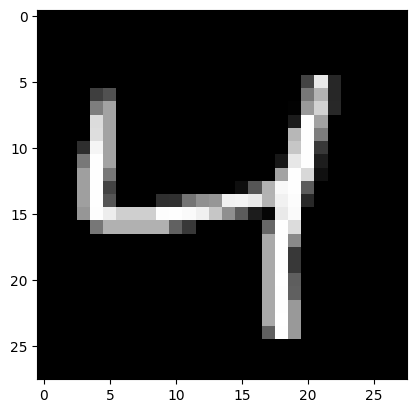

In [28]:
# visualize a single example
img, _ = train_dataset[2]
plt.imshow(img.squeeze(), cmap='gray')
print('Shape:', img.shape)   # should be [1, 64, 64]


GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [29]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super().__init__()
        # latent input: (B, latent_dims,1,1)
        self.deconv1    = nn.ConvTranspose2d(latent_dims, d*2, 7, 1, 0)  # → 7×7
        self.deconv1_bn = nn.BatchNorm2d(d*2)
        self.deconv2    = nn.ConvTranspose2d(d*2,        d, 4, 2, 1)  # → 14×14
        self.deconv2_bn = nn.BatchNorm2d(d)
        self.deconv3    = nn.ConvTranspose2d(d,          1, 4, 2, 1)  # → 28×28

    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1,   d,   4, 2, 1)  # → 14×14
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)     # →  7×7
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)   # →  3×3
        self.conv3_bn = nn.BatchNorm2d(d*4)
        # no more conv; just a FC:
        self.fc    = nn.Linear(d*4 * 3 * 3, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),    0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = x.view(x.size(0), -1)         # flatten
        return torch.sigmoid(self.fc(x)).squeeze()


device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)


# instantiate & move to device
generator     = Generator().to(device)
discriminator = Discriminator().to(device)
print(f'#G params: {sum(p.numel() for p in generator.parameters())}')
print(f'#D params: {sum(p.numel() for p in discriminator.parameters())}')



cuda:0
#G params: 778369
#D params: 2630529


Train GAN
--------


In [30]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch)
        fake_pred = discriminator(fake_image_batch.detach())
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 8.661837 vs. 0.003570
Epoch [2 / 20] average loss generator vs. discrim.: 3.383545 vs. 0.408287
Epoch [3 / 20] average loss generator vs. discrim.: 2.298284 vs. 0.296881
Epoch [4 / 20] average loss generator vs. discrim.: 2.753546 vs. 0.223695
Epoch [5 / 20] average loss generator vs. discrim.: 3.068340 vs. 0.180933
Epoch [6 / 20] average loss generator vs. discrim.: 3.296993 vs. 0.168862
Epoch [7 / 20] average loss generator vs. discrim.: 3.482698 vs. 0.138013
Epoch [8 / 20] average loss generator vs. discrim.: 3.438530 vs. 0.173802
Epoch [9 / 20] average loss generator vs. discrim.: 3.634888 vs. 0.143892
Epoch [10 / 20] average loss generator vs. discrim.: 3.814563 vs. 0.125704
Epoch [11 / 20] average loss generator vs. discrim.: 3.699287 vs. 0.152056
Epoch [12 / 20] average loss generator vs. discrim.: 4.047144 vs. 0.102027
Epoch [13 / 20] average loss generator vs. discrim.: 4.249120 vs. 0.096025
Epoch [14 / 20] avera

Plot Training Curves
--------------------

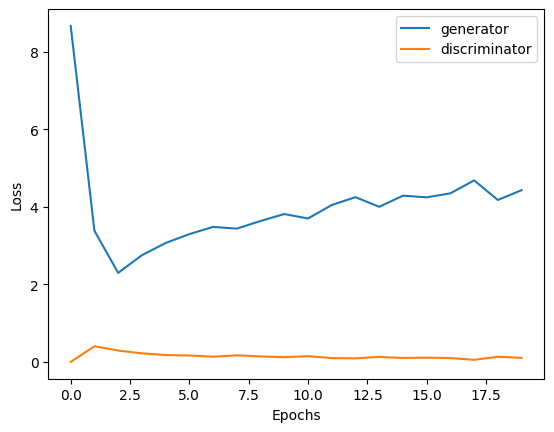

In [31]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

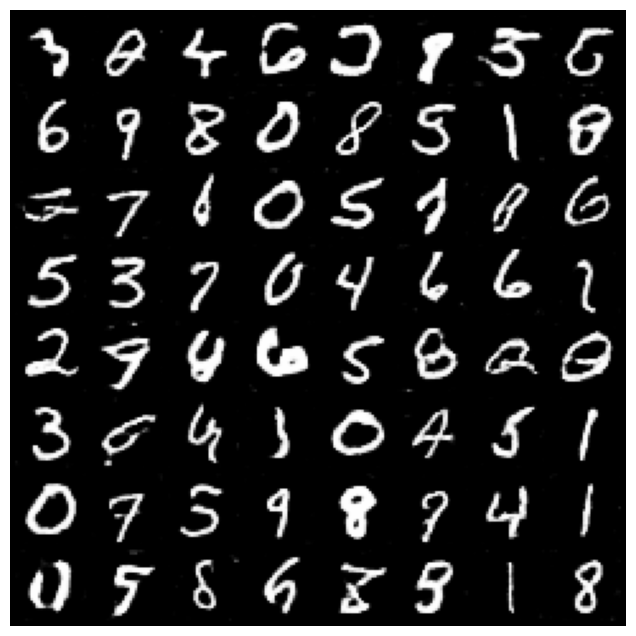

In [36]:

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample a batch of 64 latent vectors
    z = torch.randn(64, latent_dims, 1, 1, device=device)
    fake_batch = generator(z).cpu()

    grid = torchvision.utils.make_grid(
        (fake_batch*0.5 + 0.5), nrow=8, padding=2
    )
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

Interpolate in Latent Space
----------------------------

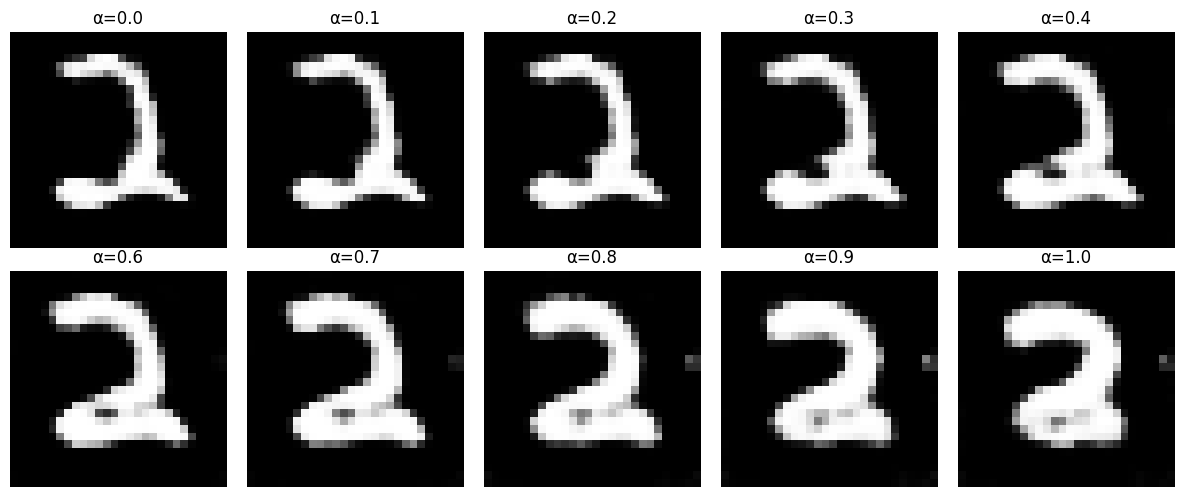

In [51]:

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# pick two random latents
latent_1 = torch.randn(1, latent_dims, 1, 1, device=device)
latent_2 = torch.randn(1, latent_dims, 1, 1, device=device)
lambda_range = np.linspace(0, 1, 10)

fig, axs = plt.subplots(2,5, figsize=(12,5))
axs = axs.flatten()

for i, α in enumerate(lambda_range):
    with torch.no_grad():
        z = α*latent_1 + (1-α)*latent_2
        img = generator(z).cpu()
        img = (img*0.5 + 0.5).squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f'α={α:.1f}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# Comments
Quality of the samples:
* The quality of the generated digits is inconsistent and seems to like combining two numbers into one. This may be because it is getting confused between certain numbers.
* The numbers have blurry edges
* The loss was unbalenced as the generator had much more loss, and started increasing loss after some epochs


Suggested improvements:
* Increase feature map depth
* stabalize training using a different loss function
* Increasing the latent_dims would help the images be
* Increase the number of epochs
* Try different learning rates
* Try upscaling images, or starting out with higher quality images, like 64 x 64
